In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

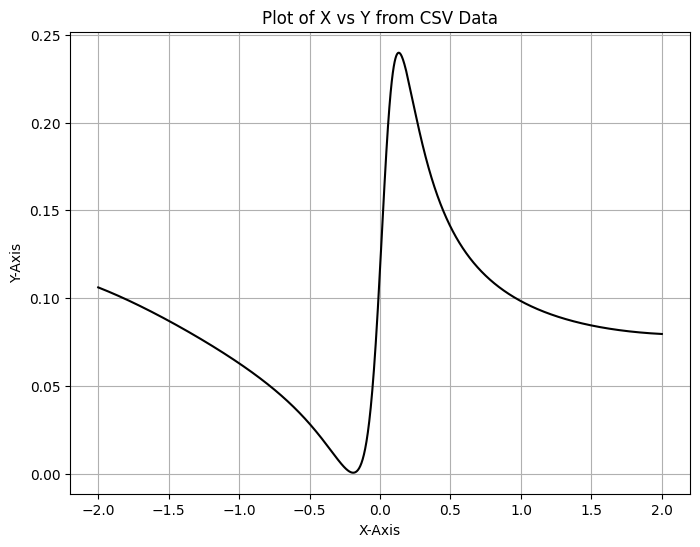

In [6]:
df = pd.read_csv('black_curve.csv')
x_values = df['xx']
y_values = df['yy']

# --- Step 4: Create the plot using matplotlib ---
plt.figure(figsize=(8, 6)) # Create a figure with a specific size
plt.plot(x_values, y_values, linestyle='-', color='black')

# --- Step 5: Add labels, a title, and a grid for clarity ---
plt.title('Plot of X vs Y from CSV Data')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.grid(True)

# --- Step 6: Display the plot ---
plt.show()

Step 0, Loss=0.001737
Step 500, Loss=0.000276
Step 1000, Loss=0.000276
Step 1500, Loss=0.000276
Step 2000, Loss=0.000276
Step 2500, Loss=0.000276
Step 3000, Loss=0.000276
Step 3500, Loss=0.000276
Step 4000, Loss=0.000276
Step 4500, Loss=0.000276

--- Fit Statistics ---
SSE       = 4.127049
R-square  = 0.887683
DFE       = 14975
Adj R-sq  = 0.887661
RMSE      = 0.016601


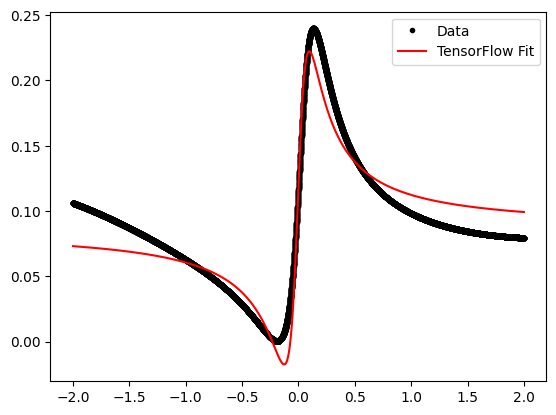

In [7]:
xx = x_values.to_numpy()
yy = y_values.to_numpy()
# Suppose xx and yy are your numpy arrays
# xx = np.array([...])
# yy = np.array([...])

# Define model function
def model_func(x, a, b, c, d):
    term1 = (a * b**2) / (1 + ((x - c) / d)**2)
    term2 = a * ((x - c) / d)**2 / (1 + ((x - c) / d)**2)
    term3 = a * (2 * b**2 * ((x - c) / d)) / (1 + ((x - c) / d)**2)
    return term1 + term2 + term3

# Convert data to tensors
X = tf.constant(xx, dtype=tf.float32)
Y = tf.constant(yy, dtype=tf.float32)

# Trainable parameters (initial guesses from MATLAB)
a = tf.Variable(0.07, dtype=tf.float32)
b = tf.Variable(-1.7, dtype=tf.float32)
c = tf.Variable(-0.03, dtype=tf.float32)
d = tf.Variable(0.09, dtype=tf.float32)
params = [a, b, c, d]

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
for step in range(5000):
    with tf.GradientTape() as tape:
        y_pred = model_func(X, a, b, c, d)
        loss = tf.reduce_mean((Y - y_pred)**2)
    grads = tape.gradient(loss, params)
    optimizer.apply_gradients(zip(grads, params))
    if step % 500 == 0:
        print(f"Step {step}, Loss={loss.numpy():.6f}")

# Predictions
y_fit = model_func(X, a, b, c, d).numpy()

# --- Statistics ---
n = len(xx)         # number of data points
p = 4               # number of parameters

SSE = np.sum((yy - y_fit)**2)
SST = np.sum((yy - np.mean(yy))**2)
R2 = 1 - SSE/SST
DFE = n - p
Adj_R2 = 1 - (SSE/DFE) / (SST/(n-1))
RMSE = np.sqrt(SSE/DFE)

print("\n--- Fit Statistics ---")
print(f"SSE       = {SSE:.6f}")
print(f"R-square  = {R2:.6f}")
print(f"DFE       = {DFE}")
print(f"Adj R-sq  = {Adj_R2:.6f}")
print(f"RMSE      = {RMSE:.6f}")

# --- Plot ---
x_grid = np.linspace(xx.min(), xx.max(), 500)
y_grid = model_func(x_grid, a.numpy(), b.numpy(), c.numpy(), d.numpy())

plt.plot(xx, yy, "k.", label="Data")
plt.plot(x_grid, y_grid, "r-", label="TensorFlow Fit")
plt.legend()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


[Adam] Epoch 0, Loss = 9.392682e-03
[Adam] Epoch 500, Loss = 2.712551e-04
[Adam] Epoch 1000, Loss = 2.355822e-04
[Adam] Epoch 1500, Loss = 2.324515e-04
[Adam] Epoch 2000, Loss = 2.323744e-04
[Adam] Epoch 2500, Loss = 2.323739e-04
[Adam] Epoch 3000, Loss = 2.323739e-04
[Adam] Epoch 3500, Loss = 2.323739e-04
[Adam] Epoch 4000, Loss = 2.323739e-04
[Adam] Epoch 4500, Loss = 2.323739e-04

Switching to LBFGS...

Best Fit Parameters:
a = 0.082832, b = -1.378745, c = 0.022709, d = -0.111573

Goodness of Fit:
SSE      = 3.480729
R-square = 0.905273
DFE      = 14975
Adj R-sq = 0.905254
RMSE     = 0.015246


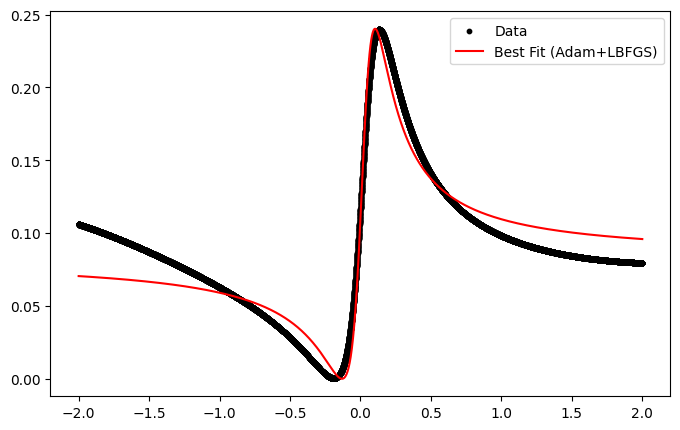

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Load dataset
# =========================
df = pd.read_csv("black_curve.csv")

# Replace with actual column names
x_values = df['xx'].values  
y_values = df['yy'].values  

# Normalize X for stability
x_mean, x_std = np.mean(x_values), np.std(x_values)
x_scaled = (x_values - x_mean) / x_std

# Torch tensors
x_train_t = torch.tensor(x_scaled, dtype=torch.float32).view(-1,1)
y_train_t = torch.tensor(y_values, dtype=torch.float32).view(-1,1)

N = len(x_values)   # number of data points
p = 4               # number of parameters (a,b,c,d)

# =========================
# 2. Define parametric model
# =========================
class ParamFit(nn.Module):
    def __init__(self, a0, b0, c0, d0):
        super(ParamFit, self).__init__()
        # Trainable parameters with good initial guesses
        self.a = nn.Parameter(torch.tensor(a0, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(b0, dtype=torch.float32))
        self.c = nn.Parameter(torch.tensor(c0, dtype=torch.float32))
        self.d = nn.Parameter(torch.tensor(d0, dtype=torch.float32))

    def forward(self, x):
        # Rescale x back to original scale
        x_orig = x * x_std + x_mean
        return (self.a*(self.b**2)/(1+((x_orig-self.c)/self.d)**2) +
                self.a*((x_orig-self.c)/self.d)**2/(1+((x_orig-self.c)/self.d)**2) +
                self.a*(2*self.b*(x_orig-self.c)/self.d)/(1+((x_orig-self.c)/self.d)**2))

# =========================
# 3. Model with initial guess
# =========================
# 👉 Replace these with MATLAB results if available
a0, b0, c0, d0 = 0.0713, -1.7316, -0.0317, 0.0946
model = ParamFit(a0, b0, c0, d0)

loss_fn = nn.MSELoss()

# =========================
# 4. Adam optimizer (warm-up)
# =========================
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"[Adam] Epoch {epoch}, Loss = {loss.item():.6e}")

# =========================
# 5. LBFGS optimizer (refine)
# =========================
optimizer = optim.LBFGS(model.parameters(), max_iter=5000, tolerance_grad=1e-12, tolerance_change=1e-12, history_size=100)

def closure():
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    return loss

print("\nSwitching to LBFGS...")
optimizer.step(closure)

# =========================
# 6. Extract learned parameters
# =========================
a_fit = model.a.item()
b_fit = model.b.item()
c_fit = model.c.item()
d_fit = model.d.item()

print("\nBest Fit Parameters:")
print(f"a = {a_fit:.6f}, b = {b_fit:.6f}, c = {c_fit:.6f}, d = {d_fit:.6f}")

# =========================
# 7. Goodness-of-fit metrics
# =========================
y_pred_np = model(x_train_t).detach().numpy().flatten()
y_true_np = y_train_t.numpy().flatten()

SSE = np.sum((y_true_np - y_pred_np)**2)
SST = np.sum((y_true_np - np.mean(y_true_np))**2)
R2 = 1 - SSE/SST
DFE = N - p
Adj_R2 = 1 - (1-R2)*(N-1)/(DFE)
RMSE = np.sqrt(SSE/DFE)

print("\nGoodness of Fit:")
print(f"SSE      = {SSE:.6f}")
print(f"R-square = {R2:.6f}")
print(f"DFE      = {DFE}")
print(f"Adj R-sq = {Adj_R2:.6f}")
print(f"RMSE     = {RMSE:.6f}")

# =========================
# 8. Plot results
# =========================
plt.figure(figsize=(8,5))
plt.scatter(x_values, y_values, label="Data", s=10, color="black")
plt.plot(x_values, y_pred_np, 'r-', label="Best Fit (Adam+LBFGS)")
plt.legend()
plt.show()
